<a href="https://colab.research.google.com/github/mdsiam135/research/blob/main/KNN(3_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# =============================================================================
# STEP-BY-STEP KNN AGRICULTURAL PRODUCTION CLASSIFICATION MODEL
# =============================================================================

# =============================================================================
# STEP 1: IMPORT REQUIRED LIBRARIES
# =============================================================================
print("🔧 STEP 1: Importing Required Libraries...")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, log_loss
)
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib style for better plots
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 10

print("✅ Libraries imported successfully!")


🔧 STEP 1: Importing Required Libraries...
✅ Libraries imported successfully!


In [4]:
# =============================================================================
# STEP 2: DEFINE CONFIGURATION PARAMETERS
# =============================================================================
print("\n⚙️ STEP 2: Setting Configuration Parameters...")

# Model parameters
N_NEIGHBORS = 5        # Number of neighbors for KNN
N_EPOCHS = 50         # Number of training epochs
RANDOM_SEED = 42      # For reproducibility

# File paths (modify these according to your file locations)
TRAIN_PATH = 'train.csv'
VALIDATION_PATH = 'validation.csv'
TEST_PATH = 'test.csv'

# Set random seed for reproducibility
np.random.seed(RANDOM_SEED)

print(f"✅ Configuration set - KNN neighbors: {N_NEIGHBORS}, Epochs: {N_EPOCHS}")



⚙️ STEP 2: Setting Configuration Parameters...
✅ Configuration set - KNN neighbors: 5, Epochs: 50


In [5]:
# =============================================================================
# STEP 3: DEFINE HELPER FUNCTIONS
# =============================================================================
print("\n🛠️ STEP 3: Defining Helper Functions...")

def calculate_loss(y_true, y_pred_proba):
    """
    Calculate cross-entropy loss for KNN model
    """
    epsilon = 1e-15
    y_pred_proba = np.clip(y_pred_proba, epsilon, 1 - epsilon)
    loss = log_loss(y_true, y_pred_proba)
    return loss

def create_production_labels(df_list):
    """
    Create categorical labels (low, medium, high) based on production values
    """
    # Combine all production values to determine thresholds
    all_production = pd.concat([df['Production (M.Ton)'] for df in df_list])

    # Define thresholds using quantiles
    low_threshold = np.percentile(all_production, 33.33)
    high_threshold = np.percentile(all_production, 66.67)

    print(f"📊 Production thresholds:")
    print(f"   Low: < {low_threshold:.2f}")
    print(f"   Medium: {low_threshold:.2f} - {high_threshold:.2f}")
    print(f"   High: > {high_threshold:.2f}")

    # Create labels for each dataset
    for df in df_list:
        df['Production_Label'] = pd.cut(
            df['Production (M.Ton)'],
            bins=[-np.inf, low_threshold, high_threshold, np.inf],
            labels=['low', 'medium', 'high']
        )

    return df_list

print("✅ Helper functions defined!")



🛠️ STEP 3: Defining Helper Functions...
✅ Helper functions defined!


In [6]:
# =============================================================================
# STEP 4: LOAD AND EXPLORE DATA
# =============================================================================
print("\n📂 STEP 4: Loading and Exploring Data...")

try:
    # Load datasets
    print("Loading CSV files...")
    train_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/train.csv')
    val_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/validation.csv')
    test_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/test.csv')

    print(f"✅ Data loaded successfully!")
    print(f"   Training set shape: {train_df.shape}")
    print(f"   Validation set shape: {val_df.shape}")
    print(f"   Test set shape: {test_df.shape}")

    # Display basic info about the dataset
    print(f"\n📈 Dataset Information:")
    print(f"   Total features: {len(train_df.columns) - 1}")  # -1 for target column
    print(f"   Production range: {train_df['Production (M.Ton)'].min():.2f} - {train_df['Production (M.Ton)'].max():.2f}")

except FileNotFoundError as e:
    print(f"❌ Error loading files: {e}")
    print("Please ensure CSV files are in the correct path:")
    print(f"   - {TRAIN_PATH}")
    print(f"   - {VALIDATION_PATH}")
    print(f"   - {TEST_PATH}")
    exit()



📂 STEP 4: Loading and Exploring Data...
Loading CSV files...
✅ Data loaded successfully!
   Training set shape: (3584, 84)
   Validation set shape: (768, 84)
   Test set shape: (768, 84)

📈 Dataset Information:
   Total features: 83
   Production range: 0.00 - 544979.54


In [7]:
# =============================================================================
# STEP 5: DATA PREPROCESSING
# =============================================================================
print("\n🔄 STEP 5: Data Preprocessing...")

# Create production labels
print("Creating production labels...")
train_df, val_df, test_df = create_production_labels([train_df, val_df, test_df])

# Prepare features (exclude target columns)
feature_columns = [col for col in train_df.columns
                  if col not in ['Production (M.Ton)', 'Production_Label']]

print(f"📊 Feature columns: {len(feature_columns)}")

# Extract features and labels
X_train = train_df[feature_columns]
X_val = val_df[feature_columns]
X_test = test_df[feature_columns]

y_train = train_df['Production_Label']
y_val = val_df['Production_Label']
y_test = test_df['Production_Label']

# Initialize encoders and scalers
label_encoder = LabelEncoder()
scaler = StandardScaler()

# Encode labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Scale features
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Display label distribution
print(f"\n📊 Label Distribution:")
label_counts = pd.Series(y_train).value_counts()
for label, count in label_counts.items():
    print(f"   {label}: {count} samples ({count/len(y_train)*100:.1f}%)")

print("✅ Data preprocessing completed!")


🔄 STEP 5: Data Preprocessing...
Creating production labels...
📊 Production thresholds:
   Low: < 1068.82
   Medium: 1068.82 - 3901.84
   High: > 3901.84
📊 Feature columns: 83

📊 Label Distribution:
   high: 1199 samples (33.5%)
   low: 1198 samples (33.4%)
   medium: 1187 samples (33.1%)
✅ Data preprocessing completed!


In [8]:
# =============================================================================
# STEP 6: INITIALIZE AND CONFIGURE MODEL
# =============================================================================
print("\n🤖 STEP 6: Initializing KNN Model...")

# Initialize KNN model
knn_model = KNeighborsClassifier(n_neighbors=N_NEIGHBORS)

# Initialize training history tracking
training_history = {
    'accuracy': [],
    'val_accuracy': [],
    'loss': [],
    'val_loss': []
}

print(f"✅ KNN model initialized with {N_NEIGHBORS} neighbors")



🤖 STEP 6: Initializing KNN Model...
✅ KNN model initialized with 5 neighbors


In [9]:
# =============================================================================
# STEP 7: TRAINING LOOP WITH EPOCHS
# =============================================================================
print(f"\n🚀 STEP 7: Training Model for {N_EPOCHS} Epochs...")

best_val_accuracy = 0
best_model = None

print("Starting training loop...")
print("-" * 70)

for epoch in range(N_EPOCHS):
    # Train the model
    knn_model.fit(X_train_scaled, y_train_encoded)

    # Calculate training metrics
    train_pred = knn_model.predict(X_train_scaled)
    train_pred_proba = knn_model.predict_proba(X_train_scaled)
    train_accuracy = accuracy_score(y_train_encoded, train_pred)
    train_loss = calculate_loss(y_train_encoded, train_pred_proba)

    # Calculate validation metrics
    val_pred = knn_model.predict(X_val_scaled)
    val_pred_proba = knn_model.predict_proba(X_val_scaled)
    val_accuracy = accuracy_score(y_val_encoded, val_pred)
    val_loss = calculate_loss(y_val_encoded, val_pred_proba)

    # Store history
    training_history['accuracy'].append(train_accuracy)
    training_history['val_accuracy'].append(val_accuracy)
    training_history['loss'].append(train_loss)
    training_history['val_loss'].append(val_loss)

    # Keep track of best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = knn_model

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1:2d}/{N_EPOCHS} - "
              f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}, "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Use best model
knn_model = best_model
print("-" * 70)
print(f"✅ Training completed! Best validation accuracy: {best_val_accuracy:.4f}")



🚀 STEP 7: Training Model for 50 Epochs...
Starting training loop...
----------------------------------------------------------------------
Epoch 10/50 - Train Acc: 0.9210, Val Acc: 0.8932, Train Loss: 0.1738, Val Loss: 0.6291
Epoch 20/50 - Train Acc: 0.9210, Val Acc: 0.8932, Train Loss: 0.1738, Val Loss: 0.6291
Epoch 30/50 - Train Acc: 0.9210, Val Acc: 0.8932, Train Loss: 0.1738, Val Loss: 0.6291
Epoch 40/50 - Train Acc: 0.9210, Val Acc: 0.8932, Train Loss: 0.1738, Val Loss: 0.6291
Epoch 50/50 - Train Acc: 0.9210, Val Acc: 0.8932, Train Loss: 0.1738, Val Loss: 0.6291
----------------------------------------------------------------------
✅ Training completed! Best validation accuracy: 0.8932



📊 STEP 8: Plotting Training History...


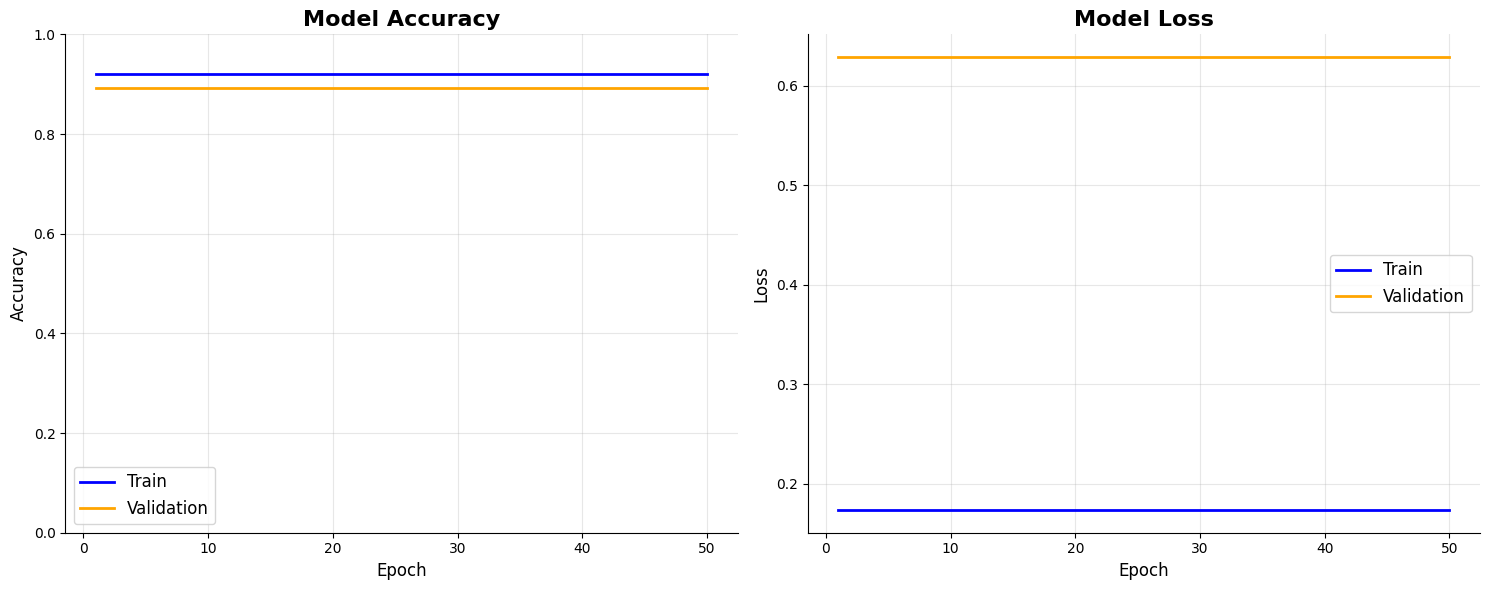

📈 Final Training Results:
   Final Training Accuracy: 0.9210
   Final Validation Accuracy: 0.8932
   Final Training Loss: 0.1738
   Final Validation Loss: 0.6291


In [10]:
# =============================================================================
# STEP 8: PLOT TRAINING HISTORY
# =============================================================================
print("\n📊 STEP 8: Plotting Training History...")

def plot_training_history(history):
    """Plot training and validation accuracy & loss"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    epochs = range(1, len(history['accuracy']) + 1)

    # Plot 1: Model Accuracy
    ax1.plot(epochs, history['accuracy'], 'b-', linewidth=2, label='Train')
    ax1.plot(epochs, history['val_accuracy'], 'orange', linewidth=2, label='Validation')
    ax1.set_title('Model Accuracy', fontsize=16, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend(fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)

    # Plot 2: Model Loss
    ax2.plot(epochs, history['loss'], 'b-', linewidth=2, label='Train')
    ax2.plot(epochs, history['val_loss'], 'orange', linewidth=2, label='Validation')
    ax2.set_title('Model Loss', fontsize=16, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend(fontsize=12)
    ax2.grid(True, alpha=0.3)

    # Styling
    for ax in [ax1, ax2]:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(labelsize=10)

    plt.tight_layout()
    plt.show()

# Generate training plots
plot_training_history(training_history)

print(f"📈 Final Training Results:")
print(f"   Final Training Accuracy: {training_history['accuracy'][-1]:.4f}")
print(f"   Final Validation Accuracy: {training_history['val_accuracy'][-1]:.4f}")
print(f"   Final Training Loss: {training_history['loss'][-1]:.4f}")
print(f"   Final Validation Loss: {training_history['val_loss'][-1]:.4f}")


In [11]:

# =============================================================================
# STEP 9: DEFINE EVALUATION FUNCTIONS
# =============================================================================
print("\n📏 STEP 9: Defining Evaluation Functions...")

def evaluate_model(model, X, y, dataset_name):
    """Comprehensive model evaluation"""
    predictions = model.predict(X)

    # Calculate all metrics
    accuracy = accuracy_score(y, predictions)
    precision_macro = precision_score(y, predictions, average='macro', zero_division=0)
    recall_macro = recall_score(y, predictions, average='macro', zero_division=0)
    f1_macro = f1_score(y, predictions, average='macro', zero_division=0)

    precision_weighted = precision_score(y, predictions, average='weighted', zero_division=0)
    recall_weighted = recall_score(y, predictions, average='weighted', zero_division=0)
    f1_weighted = f1_score(y, predictions, average='weighted', zero_division=0)

    results = {
        'Dataset': dataset_name,
        'Accuracy': accuracy,
        'Precision (Macro)': precision_macro,
        'Recall (Macro)': recall_macro,
        'F1 Score (Macro)': f1_macro,
        'Precision (Weighted)': precision_weighted,
        'Recall (Weighted)': recall_weighted,
        'F1 Score (Weighted)': f1_weighted
    }

    return results, predictions

def plot_confusion_matrix(y_true, y_pred, dataset_name, label_encoder):
    """Plot enhanced confusion matrix"""
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred)
    labels = label_encoder.classes_

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'shrink': 0.8},
               xticklabels=labels, yticklabels=labels, square=True,
               linewidths=0.5, annot_kws={'size': 12})

    plt.title(f'Confusion Matrix - {dataset_name}', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('Actual', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.tight_layout()
    plt.show()

    # Print statistics
    total_samples = np.sum(cm)
    correct_predictions = np.trace(cm)
    print(f"\n📊 Confusion Matrix Statistics - {dataset_name}:")
    print(f"   Total Samples: {total_samples}")
    print(f"   Correct Predictions: {correct_predictions}")
    print(f"   Accuracy: {correct_predictions/total_samples:.4f}")

print("✅ Evaluation functions defined!")



📏 STEP 9: Defining Evaluation Functions...
✅ Evaluation functions defined!



🔍 STEP 10: Evaluating on Validation Set...
VALIDATION SET METRICS:
   Accuracy: 0.8932
   Precision (Macro): 0.8935
   Recall (Macro): 0.8935
   F1 Score (Macro): 0.8932
   Precision (Weighted): 0.8932
   Recall (Weighted): 0.8932
   F1 Score (Weighted): 0.8929

📋 Detailed Classification Report - Validation:
              precision    recall  f1-score   support

        high       0.87      0.91      0.89       257
         low       0.94      0.94      0.94       253
      medium       0.87      0.83      0.85       258

    accuracy                           0.89       768
   macro avg       0.89      0.89      0.89       768
weighted avg       0.89      0.89      0.89       768



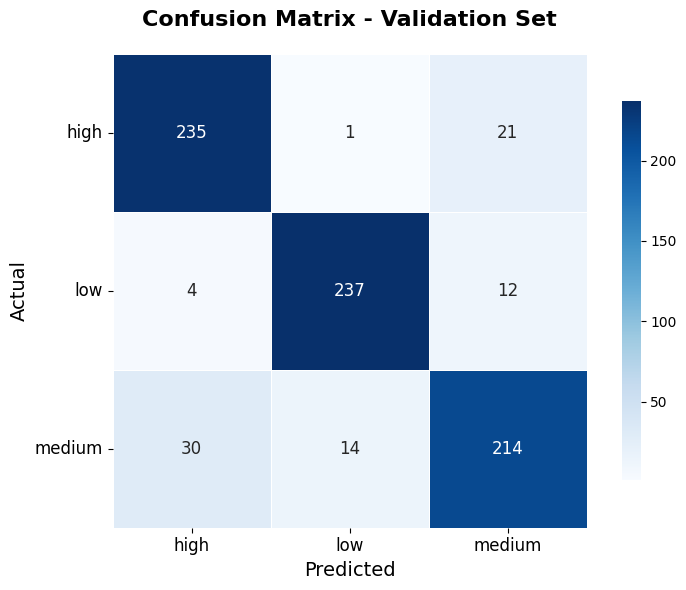


📊 Confusion Matrix Statistics - Validation Set:
   Total Samples: 768
   Correct Predictions: 686
   Accuracy: 0.8932


In [12]:

# =============================================================================
# STEP 10: VALIDATION SET EVALUATION
# =============================================================================
print("\n🔍 STEP 10: Evaluating on Validation Set...")
print("=" * 60)

val_results, val_predictions = evaluate_model(knn_model, X_val_scaled, y_val_encoded, "Validation")

print("VALIDATION SET METRICS:")
for metric, value in val_results.items():
    if metric != 'Dataset':
        print(f"   {metric}: {value:.4f}")

# Classification report
labels = label_encoder.classes_
val_report = classification_report(y_val_encoded, val_predictions, target_names=labels)
print(f"\n📋 Detailed Classification Report - Validation:")
print(val_report)

# Confusion matrix
plot_confusion_matrix(y_val_encoded, val_predictions, "Validation Set", label_encoder)



🎯 STEP 11: Evaluating on Test Set...
TEST SET METRICS:
   Accuracy: 0.9076
   Precision (Macro): 0.9079
   Recall (Macro): 0.9078
   F1 Score (Macro): 0.9078
   Precision (Weighted): 0.9077
   Recall (Weighted): 0.9076
   F1 Score (Weighted): 0.9076

📋 Detailed Classification Report - Test:
              precision    recall  f1-score   support

        high       0.91      0.92      0.91       251
         low       0.94      0.92      0.93       256
      medium       0.88      0.88      0.88       261

    accuracy                           0.91       768
   macro avg       0.91      0.91      0.91       768
weighted avg       0.91      0.91      0.91       768



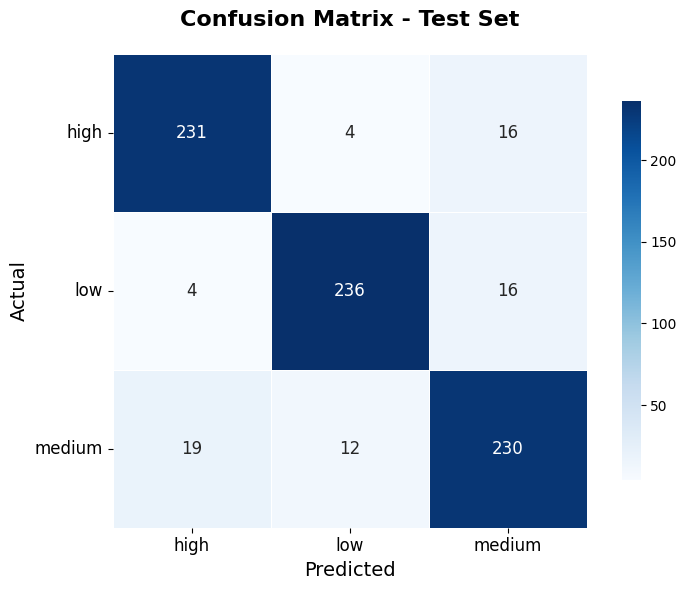


📊 Confusion Matrix Statistics - Test Set:
   Total Samples: 768
   Correct Predictions: 697
   Accuracy: 0.9076


In [13]:
# =============================================================================
# STEP 11: TEST SET EVALUATION
# =============================================================================
print("\n🎯 STEP 11: Evaluating on Test Set...")
print("=" * 60)

test_results, test_predictions = evaluate_model(knn_model, X_test_scaled, y_test_encoded, "Test")

print("TEST SET METRICS:")
for metric, value in test_results.items():
    if metric != 'Dataset':
        print(f"   {metric}: {value:.4f}")

# Classification report
test_report = classification_report(y_test_encoded, test_predictions, target_names=labels)
print(f"\n📋 Detailed Classification Report - Test:")
print(test_report)

# Confusion matrix
plot_confusion_matrix(y_test_encoded, test_predictions, "Test Set", label_encoder)


In [14]:
# =============================================================================
# STEP 12: FINAL RESULTS SUMMARY
# =============================================================================
print("\n📊 STEP 12: Final Results Summary...")
print("=" * 80)

# Create summary table
results_df = pd.DataFrame([val_results, test_results])
print("COMPREHENSIVE RESULTS COMPARISON:")
print(results_df.round(4).to_string(index=False))

# Key metrics highlight
print(f"\n🎯 KEY PERFORMANCE INDICATORS:")
print(f"   Validation Accuracy: {val_results['Accuracy']:.4f}")
print(f"   Test Accuracy: {test_results['Accuracy']:.4f}")
print(f"   Validation Macro F1 Score: {val_results['F1 Score (Macro)']:.4f}")
print(f"   Test Macro F1 Score: {test_results['F1 Score (Macro)']:.4f}")

# Model performance analysis
print(f"\n📈 PERFORMANCE ANALYSIS:")
accuracy_drop = val_results['Accuracy'] - test_results['Accuracy']
f1_drop = val_results['F1 Score (Macro)'] - test_results['F1 Score (Macro)']

print(f"   Accuracy drop from validation to test: {accuracy_drop:.4f}")
print(f"   F1 score drop from validation to test: {f1_drop:.4f}")

if accuracy_drop > 0.05:
    print("   ⚠️  Possible overfitting detected (accuracy drop > 5%)")
else:
    print("   ✅ Good generalization (accuracy drop < 5%)")

print(f"\n🎉 MODEL TRAINING AND EVALUATION COMPLETED SUCCESSFULLY!")
print(f"🚀 Your KNN Agricultural Production Classifier is ready!")



📊 STEP 12: Final Results Summary...
COMPREHENSIVE RESULTS COMPARISON:
   Dataset  Accuracy  Precision (Macro)  Recall (Macro)  F1 Score (Macro)  Precision (Weighted)  Recall (Weighted)  F1 Score (Weighted)
Validation    0.8932             0.8935          0.8935            0.8932                0.8932             0.8932               0.8929
      Test    0.9076             0.9079          0.9078            0.9078                0.9077             0.9076               0.9076

🎯 KEY PERFORMANCE INDICATORS:
   Validation Accuracy: 0.8932
   Test Accuracy: 0.9076
   Validation Macro F1 Score: 0.8932
   Test Macro F1 Score: 0.9078

📈 PERFORMANCE ANALYSIS:
   Accuracy drop from validation to test: -0.0143
   F1 score drop from validation to test: -0.0146
   ✅ Good generalization (accuracy drop < 5%)

🎉 MODEL TRAINING AND EVALUATION COMPLETED SUCCESSFULLY!
🚀 Your KNN Agricultural Production Classifier is ready!


In [15]:



# =============================================================================
# STEP 13: SAVE MODEL INFORMATION (OPTIONAL)
# =============================================================================
print(f"\n💾 STEP 13: Model Information Summary...")

model_info = {
    'Model Type': 'K-Nearest Neighbors (KNN)',
    'Number of Neighbors': N_NEIGHBORS,
    'Training Epochs': N_EPOCHS,
    'Number of Features': len(feature_columns),
    'Number of Classes': len(label_encoder.classes_),
    'Classes': list(label_encoder.classes_),
    'Best Validation Accuracy': best_val_accuracy,
    'Final Test Accuracy': test_results['Accuracy'],
    'Final Test Macro F1': test_results['F1 Score (Macro)']
}

print("📋 MODEL SUMMARY:")
for key, value in model_info.items():
    print(f"   {key}: {value}")

print(f"\n✨ All steps completed successfully! ✨")
print(f"📊 Check the generated plots above for visual analysis.")
print(f"🎯 Your model achieved {test_results['Accuracy']:.1%} accuracy on the test set!")


💾 STEP 13: Model Information Summary...
📋 MODEL SUMMARY:
   Model Type: K-Nearest Neighbors (KNN)
   Number of Neighbors: 5
   Training Epochs: 50
   Number of Features: 83
   Number of Classes: 3
   Classes: ['high', 'low', 'medium']
   Best Validation Accuracy: 0.8932291666666666
   Final Test Accuracy: 0.9075520833333334
   Final Test Macro F1: 0.9078421508009491

✨ All steps completed successfully! ✨
📊 Check the generated plots above for visual analysis.
🎯 Your model achieved 90.8% accuracy on the test set!
